In [1]:
import json
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['STHeiti', 'SimHei', 'Microsoft YaHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

base_path = Path('回测') / 'res'

strategy_files = {
    '等权配置': 'equal_weights.json',
    '动态权重(有状态)': 'dynamic_weights.json',
    '动态权重(无状态)': 'dynamic_weights_without_regime.json',
    '规则配置': 'rule_based.json',
}

strategy_data = {}
for name, fname in strategy_files.items():
    fpath = base_path / fname
    if not fpath.exists():
        raise FileNotFoundError(f'未找到回测结果文件: {fpath}')
    with open(fpath, 'r', encoding='utf-8') as f:
        strategy_data[name] = json.load(f)

print('已成功读取策略回测结果:', list(strategy_data.keys()))

已成功读取策略回测结果: ['等权配置', '动态权重(有状态)', '动态权重(无状态)', '规则配置']


In [2]:
# 构建四个策略的核心绩效指标对比表（第5组 = 高因子组合）

metrics = [
    '整体@平均收益(%)',
    '整体@标准差(%)',
    '整体@夏普比率',
    '整体@胜率(%)',
    '整体@最大回撤%(日线)',
]

summary_rows = []
for name, data in strategy_data.items():
    df_ret = pd.DataFrame(data['收益率检验'])
    row5 = df_ret[df_ret['组名'] == '第5组'].iloc[0]

    # 最终累计收益率（取“累计收益率”中第5组与基准的最后一个值）
    df_cum = pd.DataFrame(data['累计收益率'])
    final_port = df_cum['第5组'].iloc[-1]
    final_bench = df_cum['基准'].iloc[-1]

    summary = {
        '策略': name,
        '最终累计收益(第5组, %)': final_port,
        '基准最终累计收益(%)': final_bench,
    }
    for m in metrics:
        summary[m] = row5[m]
    summary_rows.append(summary)

summary_df = pd.DataFrame(summary_rows).set_index('策略')
summary_df.round(2)

,"最终累计收益(第5组, %)",基准最终累计收益(%),整体@平均收益(%),整体@标准差(%),整体@夏普比率,整体@胜率(%),整体@最大回撤%(日线)
策略,,,,,,,
等权配置,17.42,10.03,1.97,6.26,0.32,55.56,-13.96
动态权重(有状态),29.77,10.03,3.28,9.04,0.36,66.67,-16.91
动态权重(无状态),32.46,10.03,3.45,8.14,0.42,77.78,-11.99
规则配置,18.93,10.03,2.36,9.99,0.24,55.56,-21.54


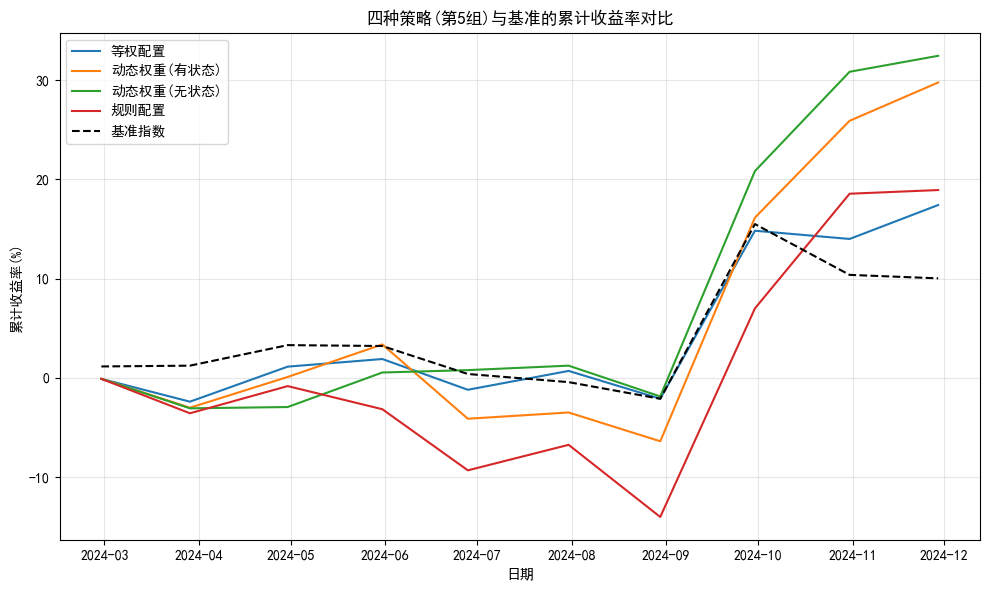

In [3]:
# 四个策略与基准的累计收益率对比曲线（第5组组合）

cum_series = {}
benchmark = None

for name, data in strategy_data.items():
    df_cum = pd.DataFrame(data['累计收益率']).copy()
    df_cum['截止日'] = pd.to_datetime(df_cum['截止日'])
    df_cum.set_index('截止日', inplace=True)

    # 记录策略本身（第5组）
    cum_series[name] = df_cum['第5组']

    # 记录一次基准曲线
    if benchmark is None:
        benchmark = df_cum['基准']

cum_all = pd.concat(cum_series, axis=1)

plt.figure(figsize=(10, 6))
for col in cum_all.columns:
    plt.plot(cum_all.index, cum_all[col], label=col)

plt.plot(benchmark.index, benchmark.values, label='基准指数', linestyle='--', color='black')
plt.xlabel('日期')
plt.ylabel('累计收益率(%)')
plt.title('四种策略(第5组)与基准的累计收益率对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()